# Using word2vec to Color Words

In [2]:
import json
import nlp

import numpy as np

from sklearn import manifold
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline 

dataset = 'lss' # lss/asm
input_file = '../data/lss-17k.json'
output_file = '../data/lss-17k-color-lookup.json'

if dataset == 'asm':
    input_file = '../data/lss_asm_dataset.txt'
    output_file = '../data/lss-asm-color-lookup.json'

###  Load data

In [3]:
def load(filename):
    'A text file with each line as a JSON text.'
    p = parse_asm if dataset == 'asm' else parse_lss
    with open(filename) as file:
        sessions = [p(line) for line in file]
    return [s for s in sessions if s]

def parse_asm(text):
    'Return the list of actions from the given JSON text.'
    obj = json.loads(text)
    if 'actions' in obj and obj['actions'] and len(obj['actions']) <= 150: # limit max length to sync with the vis
        action = [a['name'][6:] for a in obj['actions']] #  [6:] to exclude the prefix 'Action'
        return { 'id': obj['session']['dcxID'], 'action': action }

def parse_lss(text):
    'Return the list of actions from the given JSON text.'
    obj = json.loads(text)
    if 'actionsQueue' in obj and obj['actionsQueue'] and obj['userId'] != 'none' and obj['officeId'] != 'none' and obj['orga'] != 'none':
        action = [a[6:] for a in obj['actionsQueue']] #  [6:] to exclude the prefix 'Action'
        return { 'id': obj['PFX'], 'action': action }

In [4]:
data = load(input_file)
docs = [d['action'] for d in data]
len(data), data[0]

(14910,
 {'action': ['SearchOffice',
   'DisplayOneOffice',
   'SearchUsr',
   'SearchUsr',
   'DisplayOneUser',
   'UpdateUserDetails',
   'UpdateUserDetails',
   'SearchUsr',
   'DisplayOneUser',
   'CreateUser'],
  'id': ':M6KR03#GP1LS1CETBTJB3N#T91:'})

### word2vec

In [5]:
word2vec = nlp.build_word2vec(docs)
wordvecs = word2vec.wv

We can apply t-sne projection to show all terms in the dictionary.

In [6]:
matrix = np.concatenate([wordvecs[t].reshape(1, -1) for t in wordvecs.vocab])
coords = manifold.TSNE(perplexity=100, random_state=0).fit_transform(matrix)

### 2D projection as HSL color wheel

In [7]:
import colorsys

def angle_between(v1, v2):
    return np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * (np.linalg.norm(v2))))

def get_h(x, y):
    a = angle_between((x, y), (1, 0)) / np.pi / 2
    return a if y >= 0 else 1 - a

def get_max_xy(points):
    'Fit the points into a circle, centering at (0, 0). Return the radius of the circle.'
    return max(np.linalg.norm(p) for p in points)

def get_s(x, y, scale):
    return np.linalg.norm((x, y)) / scale
    
def get_2dcolor(points):
    max_xy = get_max_xy(points)
    return [colorsys.hls_to_rgb(get_h(*p), 0.5, get_s(*p, max_xy)) for p in points]

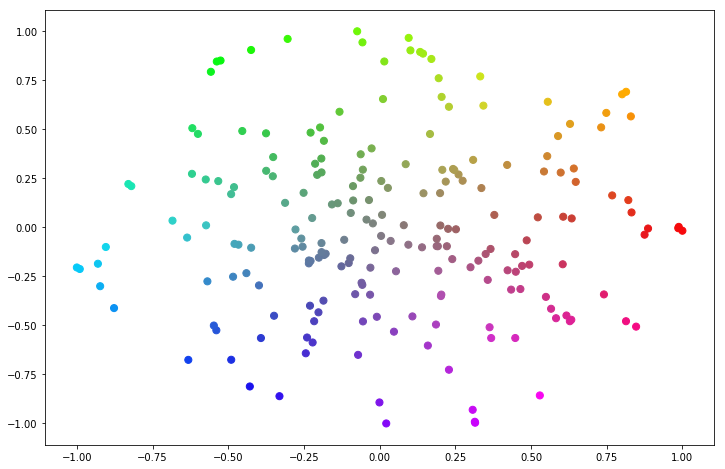

In [8]:
coords = MinMaxScaler(feature_range=(-1,1)).fit_transform(coords)
colors = get_2dcolor(coords)
plt.figure(figsize=(12,8))
plt.scatter(coords[:,0], coords[:,1], c=colors, s=50)
plt.show()

### Export RGB colors of terms

In [9]:
terms = list(wordvecs.vocab.keys())
hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(r * 255), int(g * 255), int(b * 255)) for r, g, b in colors]
color_lookup = {terms[i]:c for i, c in enumerate(hex_colors)} 

with open(output_file, 'w') as f:
    json.dump(color_lookup, f)